In [41]:
# magics to use matplotlib in a notebook
# THIS CODE IS NOT PART OF ESIO
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt  #, mpld3

import numpy as np
import numpy.ma as ma
import os
import xarray as xr
import glob
import datetime
import pandas as pd

import dask
# from dask.distributed import Client

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


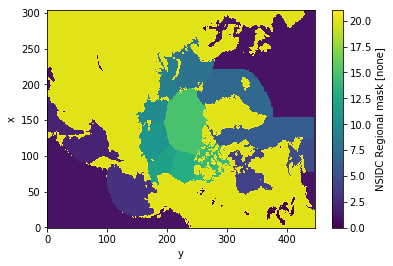

In [3]:
# read in the region mask and plot it for sanity check
ds_region = xr.open_dataset(os.path.join('/home/disk/sipn/nicway/data/grids', 'sio_2016_mask_Update.nc'))
ds_region.mask.plot()

In [4]:
# aggregate the data into regions using the NSIDC region mask 
# do this two ways 
#  1) using a threshold on every grid cell whose SIC > 0.15 and without weighting by SIC (giving "extent")
#  2) without any threshold but using SIC weighting (giving "area")

# beware that I have not filled the pole hole out of laziness so the area in any region that overlaps the pole hole
# is corrupted. So definitely do not trust the central Arctic

# the two methods are selected by setting extent_thress=0.15 or 0.0

def agg_by_domain(da_grid=None, ds_region=None, extent_thress=0.15, fill_pole_hole=False):
    ds_list = []
    for cd in ds_region.nregions.values:
        # Get name
        region_name = ds_region.region_names.sel(nregions=cd).values
        # Check we want it (exclude some regions)
        if not region_name in ['Ice-free Oceans', 'null','land outline', 'land' ]:
            # Make mask
            cmask = ds_region.mask==cd
            if extent_thress>0.00001:
                # Multiple by cell area to get area of sea ice
                da_avg = (da_grid.where(cmask==1) >= extent_thress).astype('int') * ds_region.area.where(cmask==1)
            else:
                da_avg = da_grid.where(cmask==1) * ds_region.area.where(cmask==1)
            # Sum up over current domain and convert to millions of km^2
            da_avg = da_avg.sum(dim=['y','x']) / (10**6)
            # TODO: Add option to add in pole hole if obs and central arctic
            if fill_pole_hole:
                raise ValueError('Not implemented')

            # Add domain name
            da_avg['nregions'] = cd
            da_avg['region_names'] = region_name
            ds_list.append(da_avg)
    return xr.concat(ds_list, dim='nregions')



In [32]:
# read in all the ugly binary files into a pleasant xarray

in_dir = '/home/disk/sipn/nicway/data/obs/NSIDC_0051/monthly'
c_files = sorted(glob.glob(in_dir+'/nt_*_v1.1_n.bin'))
ice_max = 250
hole_mask = 251
coast = 253
land = 254
missing = 255
n_rows=448
n_cols=304

da_all = []
for cfile in c_files:
    with open(cfile, 'rb') as fr:
        hdr = fr.read(300)
        ice = np.fromfile(fr, dtype=np.uint8)
        
    ice = ice.reshape(n_rows, n_cols)
    #ice = np.flipud(ice) # need to flip column-wise or else it is at odds with the region mask
    # Make xarray dataArray
    daraw = xr.DataArray(ice, coords={'x': ds_region.x, 'y': ds_region.y}, dims=('y', 'x'))
    # Scale to (0-1) and mask out non-sic
    da = (daraw/ice_max)
    da.name = 'sic'
    da = da.where(da<=1).to_dataset()
    # Add date
    date1 = cfile.split('_')[2]
    yyyy = int(date1[0:4])
    mm = int(date1[4:6])
    dd = int(1)
    da.coords['time'] =  datetime.datetime(yyyy,mm,dd)
    da.expand_dims('time')
    #if get_masks:
    # Add other masks
    da.coords['hole_mask'] = daraw==hole_mask
    da = da.sic
    da = da.expand_dims('time')
    da_all.append(da)

da_all=xr.concat(da_all,dim='time').transpose('time','x','y')
print(da_all)

<xarray.DataArray 'sic' (time: 460, x: 304, y: 448)>
array([[[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       ...,

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]]])
Coordinates:
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
  * time       (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2017-02-01
    hole_mask  (time, y, x) bool False False False False ... False Fa

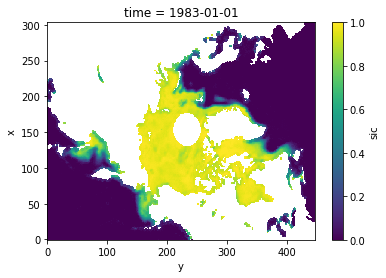

In [33]:
da_all.isel(time=50).plot() # verify that a random time has same orientation as the mask
                            # try a few points in time to observe the pole hole or whatever

In [ ]:
# use our subroutine about to compute the regional means in the two ways mentioned
da_EReg=agg_by_domain(da_grid=da_all, ds_region=ds_region, extent_thress=0.15, fill_pole_hole=False)
da_AReg=agg_by_domain(da_grid=da_all, ds_region=ds_region, extent_thress=0., fill_pole_hole=False)

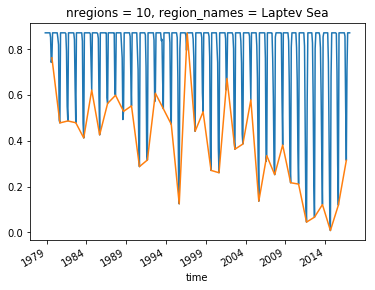

In [42]:
# Extent by Region
da_EReg.sel(nregions=10).plot()
da_EReg.sel(nregions=10,time=slice('1979-09-01', '2016-09-01',12)).plot() # pretty convinced this does plot SEP only

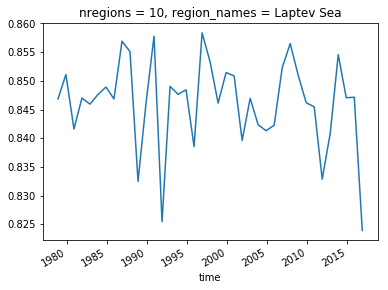

In [35]:
# Area for my favorite region in Dec, what abrupt change?
da_AReg.sel(nregions=10,time=slice('1978-12-01', '2016-12-01',12)).plot()  
plt.savefig('/home/disk/sipn/bitz/Laptev_Sea_DEC.png')

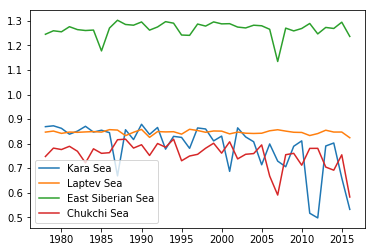

In [36]:
yrs=np.arange(1978,2017) # no abrupt change here either, hmmm.
line=plt.plot(yrs,da_AReg.sel(nregions=np.arange(9,13),time=slice('1978-12-01', '2016-12-01',12)).transpose())
plt.legend(da_AReg.region_names.sel(nregions=np.arange(9,13)).values)
plt.savefig('/home/disk/sipn/bitz/Several_DEC.png')

Let's look at our data

In [38]:
da_AReg

<xarray.DataArray (nregions: 14, time: 460)>
array([[0.036554, 0.312323, 1.044967, ..., 0.199155, 0.459998, 0.575689],
       [0.034646, 0.137413, 0.172352, ..., 0.07778 , 0.179679, 0.345136],
       [0.643528, 1.13039 , 1.166953, ..., 0.663473, 1.110609, 1.172807],
       ...,
       [0.864348, 0.878169, 0.873571, ..., 0.915511, 0.909913, 0.920201],
       [0.709833, 0.720491, 0.712603, ..., 0.723442, 0.745241, 0.744884],
       [1.905196, 1.946191, 1.956338, ..., 2.743128, 2.883791, 2.993389]])
Coordinates:
  * time          (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2017-02-01
  * nregions      (nregions) int64 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    region_names  (nregions) <U18 'Sea of Okhotsk' 'Bering' ... 'Central Arctic'

In [39]:
da_AReg.region_names.values

array(['Sea of Okhotsk', 'Bering', 'Hudson Bay', 'St John', 'Baffin Bay',
       'East Greenland Sea', 'Barents Sea', 'Kara Sea', 'Laptev Sea',
       'East Siberian Sea', 'Chukchi Sea', 'Beaufort Sea',
       'Canadian Islands', 'Central Arctic'], dtype='<U18')

In [ ]:
# FYI
seasonals=da_AReg.resample(time="Q-DEC").mean(dim='time') # this should compute DJF, MAM, JJA, SON means

Ignore the rest unless you want to explore the CDR

In [240]:
# The cdR starts in 1987 so I decided not to use it today but it here if you want it
in_dir = '/home/disk/eos11/bitz/observations/seaice/data'
c_files = sorted(glob.glob(in_dir+'/*v03r01.nc'))
ds = xr.open_mfdataset(c_files,concat_dim='time', parallel=True)
ds.rename({'xgrid':'x','ygrid':'y'}, inplace=True);
ds.coords['x']=ds_region.x
ds.coords['y']=ds_region.y
ds=ds.seaice_conc_monthly_cdr
ds=ds.transpose('time','x','y')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/conventions.py:394: SerializationWarning: variable 'melt_onset_day_seaice_conc_monthly_cdr' has multiple fill values {-1, 65535}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The inplace argument has been deprecated and will be removed in xarray 0.12.0.
  """


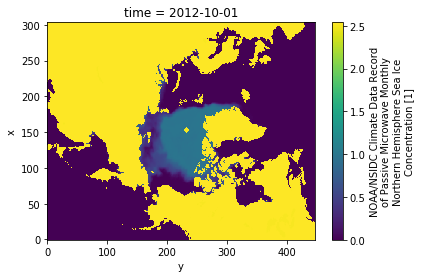

In [242]:
ds.isel(time=300).plot() 